In [ ]:
!pip install torch==1.9.0 torchvision==0.10.0 torchaudio==0.9.0

     |████████████████████████████████| 831.4 MB 2.6 kB/s 
     |████████████████████████████████| 22.1 MB 1.4 MB/s 
     |████████████████████████████████| 1.9 MB 61.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import torchvision
from torchvision import io
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict

## Load the data
* Source of the data: https://github.com/lindawangg/COVID-Net
* I've taken the data from: https://drive.google.com/drive/folders/10PIW4rpVU8AETpNDZpyxPmJo00vOwJE7
* The data were gathered by Dominik Chodounský for his bachelor thesis: https://dspace.cvut.cz/handle/10467/95031

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!jar xvf gdrive/MyDrive/Diploma/COVIDx8B.zip

Streaming output truncated to the last 5000 lines.
 inflated: COVIDx8B/train/negative/c8f8c1af-28f3-420d-85d6-9501a8002097.png
 inflated: COVIDx8B/train/negative/c907dcd1-6011-430b-9515-009900b4a98f.png
 inflated: COVIDx8B/train/negative/c90a1623-b7a2-443b-a20c-a3915df8dac2.png
 inflated: COVIDx8B/train/negative/c90ba168-4d65-4205-90e5-4f96d693d54a.png
 inflated: COVIDx8B/train/negative/c90cbfe6-d98f-407b-b3c2-45b27fd1ae72.png
 inflated: COVIDx8B/train/negative/c919262d-e632-4d1b-9d92-7a8923258ae3.png
 inflated: COVIDx8B/train/negative/c91c57aa-ced9-4499-a231-36b78e5fa786.png
 inflated: COVIDx8B/train/negative/c91c84ab-e310-43fb-adfb-9d351786b01f.png
 inflated: COVIDx8B/train/negative/c93f9fee-9ad2-43a8-9071-ba769cbbdf8a.png
 inflated: COVIDx8B/train/negative/c9449bea-76b0-42e0-827b-2677f6c2f1c8.png
 inflated: COVIDx8B/train/negative/c9464c74-1f7f-41a2-a6ac-c72e8afcbb00.png
 inflated: COVIDx8B/train/negative/c94652f9-22cd-48d2-bb01-5f54abbb7d72.png
 inflated: COVIDx8B/train/negative/c9

In [ ]:
!rm -rf 'COVIDx8B/train/negative/.ipynb_checkpoints'

In [ ]:
import sys
sys.path.append('gdrive/MyDrive/Diploma')
import image_preprocessing

## Prepare the dataset in the pytorch format

In [ ]:
ROOT_PATH = 'COVIDx8B'
TRAIN_DIR = os.path.join(ROOT_PATH, 'train')
TEST_DIR = os.path.join(ROOT_PATH, 'test')

'''
loader = DataLoader(train_data, batch_size=100, num_workers=1)

means_sum = 0
means_std = 0
for batch, _ in loader: 
  means_sum += len(batch)*torch.mean(batch, dim=[0, 2, 3])
  means_std += len(batch)*torch.std(batch, dim=[0, 2, 3])

mean = means_sum / len(train_data)
std = means_std / len(train_data)

print(mean)
print(std)
'''

img_size = (224, 224)

# needed for normalization, was calculated using the code above
train_mean = (0.4969, 0.4969, 0.4969)
train_std = (0.2445, 0.2445, 0.2445)

In [ ]:
class Covidx8bDataset(Dataset):
  def __init__(self, img_dir, transform=None):
    self.img_paths = [os.path.join(img_dir, 'negative') + '/' + img_file for img_file in os.listdir(os.path.join(img_dir, 'negative'))] \
                     + [os.path.join(img_dir, 'positive') + '/' + img_file for img_file in os.listdir(os.path.join(img_dir, 'positive'))] 
    self.img_labels = np.concatenate((np.full(shape=(len(os.listdir(os.path.join(img_dir, 'negative'))), ), fill_value=0), 
                                      np.full(shape=(len(os.listdir(os.path.join(img_dir, 'positive'))), ), fill_value=1)))
    self.transform = transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    image = Image.open(img_path).convert('RGB')
    label = self.img_labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

## Preprocessing
* resize to 224x224
* convert to pytorch tensor
* use contrast limited adaptive histogram equalization (CLAHE) with 40 clip limits

In [ ]:
class CLAHE(object):
  def __call__(self, img):
    img = 255 * np.array(img.permute(1, 2, 0))
    _, new_img = image_preprocessing.rgb_clahe(img, clip_limit=40)
    back2tensor = transforms.ToTensor()

    return back2tensor(new_img)

In [ ]:
transform = transforms.Compose([
  transforms.Resize((img_size[0], img_size[1])),
  transforms.ToTensor(),
  CLAHE(),
  #transforms.Normalize(train_mean, train_std)                         
])

In [ ]:
#train_data = Covidx8bDataset(TRAIN_DIR, transform=transform)
train_data, val_data = torch.utils.data.random_split(Covidx8bDataset(TRAIN_DIR, transform=transform), [13000, 2952], generator=torch.Generator().manual_seed(1))
test_data = Covidx8bDataset(TEST_DIR, transform=transform)
print(f'train data len = {len(train_data)}')
print(f'val data len = {len(val_data)}')
print(f'test data len = {len(test_data)}')

train data len = 13000
val data len = 2952
test data len = 400


In [ ]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

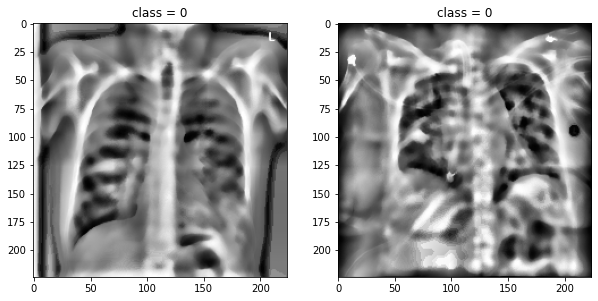

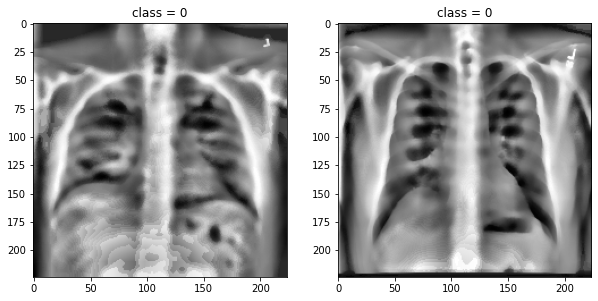

In [ ]:
loader = DataLoader(train_data, batch_size=100, num_workers=1, shuffle=True)
batch = next(iter(loader))

for k in range(2):  
  fig, ax = plt.subplots(1,2,figsize=(10,8))
  for i in range(2):
    j = np.random.randint(64)
    ax[i].imshow(batch[0][j].permute(1, 2, 0))
    ax[i].set_title('class = ' + str(batch[1][j].item()))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
train_class_weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_data.dataset.img_labels[train_data.indices]) ,dtype=torch.float).to(device)
print(train_class_weights)

tensor([0.5781, 3.6995], device='cuda:0')


## Model 1) ResNet50 fine-tuning (no class balancing)

In [ ]:
model = torchvision.models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 2)
model.load_state_dict(torch.load('gdrive/MyDrive/Diploma/model_weights/resnet50_save.pth'))
model.to(device)
model.eval()

for text, dataloader in [('train', train_dataloader), ('val', val_dataloader), ('test', test_dataloader)]:
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the {total} {text} images: {100 * correct / total}')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Accuracy of the network on the 13000 train images: 99.97692307692307
Accuracy of the network on the 2952 val images: 97.69647696476964
Accuracy of the network on the 400 test images: 90.75


In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

import gc
gc.collect()

59

## Model 2) ResNet50 fine-tuning (with class balancing)

In [ ]:
model = torchvision.models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 2)
model.load_state_dict(torch.load('gdrive/MyDrive/Diploma/model_weights/resnet50_weighted_save.pth'))
model.to(device)
model.eval()

for text, dataloader in [('train', train_dataloader), ('val', val_dataloader), ('test', test_dataloader)]:
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the {total} {text} images: {100 * correct / total}')

Accuracy of the network on the 13000 train images: 99.98461538461538
Accuracy of the network on the 2952 val images: 97.79810298102981
Accuracy of the network on the 400 test images: 95.0


In [ ]:
del model 

with torch.no_grad():
    torch.cuda.empty_cache()

import gc
gc.collect()

68

## 3) DenseNet121 fine-tunin (without weighted samples)
* I've lost the training loop output for this model and just re-running for the sake of it didn't feel neccessary

In [ ]:
model = torchvision.models.densenet121(pretrained=True)
model.classifier = nn.Linear(1024, 2)
model.load_state_dict(torch.load('gdrive/MyDrive/Diploma/model_weights/dense121_save.pth'))
model.to(device)
model.eval()

for text, dataloader in [('train', train_dataloader), ('val', val_dataloader), ('test', test_dataloader)]:
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the {total} {text} images: {100 * correct / total}')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Accuracy of the network on the 13000 train images: 99.0
Accuracy of the network on the 2952 val images: 96.27371273712737
Accuracy of the network on the 400 test images: 94.0


## Model 4) DenseNet121 fine-tuning (with class balancing)

In [ ]:
model = torchvision.models.densenet121(pretrained=True)
model.classifier = nn.Linear(1024, 2)
model.load_state_dict(torch.load('gdrive/MyDrive/Diploma/model_weights/dense121_weighted_save.pth'))
model.to(device)
model.eval()

for text, dataloader in [('train', train_dataloader), ('val', val_dataloader), ('test', test_dataloader)]:
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the {total} {text} images: {100 * correct / total}')

Accuracy of the network on the 13000 train images: 97.9076923076923
Accuracy of the network on the 2952 val images: 95.56233062330624
Accuracy of the network on the 400 test images: 93.75


## Model 6) CheXnet fine-tuning (without class balancing)

In [ ]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        self.densenet121.classifier = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.densenet121(x)
        return x

model = DenseNet121(2).cuda()
model = torch.nn.DataParallel(model).cuda()
model.load_state_dict(torch.load('gdrive/MyDrive/Diploma/model_weights/chexnet_weighted_save.pth'), strict=False)
model.eval()

for text, dataloader in [('train', train_dataloader), ('val', val_dataloader), ('test', test_dataloader)]:
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the {total} {text} images: {100 * correct / total}')

Accuracy of the network on the 13000 train images: 99.99230769230769
Accuracy of the network on the 2952 val images: 97.22222222222223
Accuracy of the network on the 400 test images: 91.75


## Model 5) CheXnet fine-tuning (with class balancing)

In [ ]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        self.densenet121.classifier = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.densenet121(x)
        return x

model = DenseNet121(2).cuda()
model = torch.nn.DataParallel(model).cuda()
model.load_state_dict(torch.load('gdrive/MyDrive/Diploma/model_weights/chexnet_save.pth'), strict=False)
model.eval()

for text, dataloader in [('train', train_dataloader), ('val', val_dataloader), ('test', test_dataloader)]:
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the {total} {text} images: {100 * correct / total}')

Accuracy of the network on the 13000 train images: 99.98461538461538
Accuracy of the network on the 2952 val images: 97.08672086720867
Accuracy of the network on the 400 test images: 93.25


In [ ]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        self.densenet121.classifier = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.densenet121(x)
        return x

model = DenseNet121(2).cuda()
model = torch.nn.DataParallel(model).cuda()
model.load_state_dict(torch.load('gdrive/MyDrive/Diploma/model_weights/chexnet_weighted_lr0.00001_save.pth'), strict=False)
model.eval()

for text, dataloader in [('train', train_dataloader), ('val', val_dataloader), ('test', test_dataloader)]:
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the {total} {text} images: {100 * correct / total}')

Accuracy of the network on the 13000 train images: 99.7
Accuracy of the network on the 2952 val images: 95.76558265582656
Accuracy of the network on the 400 test images: 90.0
